In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import json
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import f1_score

EMD_DIM = 300
def is_char(line):
    for w in line:
        if not ('\u4e00' <= w and w <= '\u9fff'):
            return False
    return True


class Embedding:
    def __init__(self, embed_file='../data/wordem.json'):
        with open(embed_file, 'r') as f:
            self.dic = json.load(f)
        for k in self.dic:
            self.dic[k] = np.array(self.dic[k])

    def embed(self, line):
        emb = np.zeros(EMD_DIM)
        cnt = 0
        for seg in line.split():
            if seg in self.dic:
                emb += self.dic[seg]
                cnt += 1
        emb /= cnt
        return emb

    def emb_dic(self):
        return self.dic


class MyDataset(Dataset):
    """params: name, embed_file_path, name in ['train', 'test']"""
    def __init__(self, name, embed_path='../data/wordem.json', mode='int'):
        super(Dataset, self).__init__()
        self.embed = Embedding(embed_path)
        # with open('../data/' + name + '.text', 'r') as f:
            # text = json.load(f)
        # with open('../data/' + name + '.label', 'r') as f:
            # label = json.load(f)
        with open('../data/{}_text_label.json'.format(name), 'r') as f:
            text_label = json.load(f)
        text, label = text_label[0], text_label[1]
        self.feat = torch.Tensor([self.embed.embed(l) for l in text])
        if mode == 'int':
            self.label = [np.array(l[1:]) for l in label]
        elif mode == 'prob' or mode == 'float':
            self.label = list()
            for l in label:
                tot_vote = l[0]
                prob = np.array([vote / tot_vote for vote in l[1:]])
                self.label.append(prob)
            self.label = torch.Tensor(self.label)

    def __len__(self):
        return len(self.label)

    def __getitem__(self, item):
        return self.feat[item], self.label[item]

In [2]:
class TwoLayerNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        """
            使用nn.Sequential让结构更加清晰
        """
        super(TwoLayerNet, self).__init__()
        self.twolayernet = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        # x = np.mat(x)
        # x = x.view(-1, 300)
        """
            TwoLayerNet(input) will automatically call 'forward' function
        """
        x = x.view(-1, 300)
        y_pred = self.twolayernet(x)
        return y_pred


In [4]:
# train part
BATCH_SIZE = 64
lr = 0.001
EPOCHS = 20
EMBED_FILE_PATH = '../data/wordem.json'
input_size, hidden_size, output_size = 300, 100, 8
trainset = MyDataset(name='train', embed_path=EMBED_FILE_PATH, mode='float')
testset = MyDataset(name='test', embed_path=EMBED_FILE_PATH, mode='float')

print(len(trainset))
print(len(testset))

2342
2228


In [5]:
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False)

In [37]:
# net2 = TwoLayerNet(input_size, hidden_size, output_size)
# net2.load_state_dict(torch.load('new_mlp_para.dict'))
# net2.eval()

# cnt = 0
# # for feat, label in testset:
# pred_emotions = list()
# true_emotions = list()
# for feat, label in testset:
#     if torch.argmax(net2(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
#         cnt += 1
#     pred_emotions.append(int(torch.argmax(net2(torch.Tensor(feat))).item()))
#     true_emotions.append(int(torch.argmax(torch.Tensor(label)).item()))
    
# print('correct:', cnt)
# print('ratio:', cnt / test_size)


# # 返回值的第一项是皮尔森相关系数，第二项是p_value值。一般来说皮尔森相关系数越大，p_value越小，线性相关性就越大。但是看到note里讲的。p_value不是完全的可靠，当数据量大于500的时候，可能是合理的。
# pears = list()
# for feat, label in testset:
#     pred = torch.Tensor(net2(feat)[0]).detach().numpy()
#     pears.append(pearsonr(label, pred))

# print('corr:', np.mean(corr))
# print('f_score_macro:', f1_score(true_emotions, pred_emotions, average='macro'))
# print('f_score_micro:', f1_score(true_emotions, pred_emotions, average='micro'))
# print('f_score_weighted:', f1_score(true_emotions, pred_emotions, average='weighted'))
# # corr -> 0.6611378491929296
# # ma -> 0.3289856648150263
# # mi -> 0.5501562344438627

correct: 1178
ratio: 0.5287253141831239
corr: 0.5339594049413392
f_score_macro: 0.31229747452666357
f_score_micro: 0.5287253141831239
f_score_weighted: 0.505048429381082


In [66]:
def score_cor_ma_mi_wei(net2):
    net2.eval()
    cnt = 0
    # for feat, label in testset:
    pred_emotions = list()
    true_emotions = list()
    for feat, label in testset:
        if torch.argmax(net2(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            cnt += 1
        pred_emotions.append(int(torch.argmax(net2(torch.Tensor(feat))).item()))
        true_emotions.append(int(torch.argmax(torch.Tensor(label)).item()))
    # print('correct:', cnt)
    # print('ratio:', cnt / test_size)

    # 返回值的第一项是皮尔森相关系数，第二项是p_value值。一般来说皮尔森相关系数越大，p_value越小，线性相关性就越大。但是看到note里讲的。p_value不是完全的可靠，当数据量大于500的时候，可能是合理的。
    pears = list()
    for feat, label in testset:
        pred = torch.Tensor(net2(feat)[0]).detach().numpy()
        pears.append(pearsonr(label, pred))

    # print('corr:', np.mean(corr))
    # print('f_score_macro:', f1_score(true_emotions, pred_emotions, average='macro'))
    # print('f_score_micro:', f1_score(true_emotions, pred_emotions, average='micro'))
    # print('f_score_weighted:', f1_score(true_emotions, pred_emotions, average='weighted'))
    return [np.mean(pears), f1_score(true_emotions, pred_emotions, average='macro'), 
           f1_score(true_emotions, pred_emotions, average='micro'), f1_score(true_emotions, pred_emotions, average='weighted')]
    # corr -> 0.6611378491929296
    # ma -> 0.3289856648150263
    # mi -> 0.5501562344438627

In [67]:
score_cor_ma_mi_wei(model)

[0.4117730441425394,
 0.21381329484489636,
 0.5677737881508079,
 0.45579837359869235]

In [68]:
# bert slower
train_loss_list = list()
train_ratio_list = list()
test_loss_list = list()
test_ratio_list = list()
corr_list = list()
macro_list = list()
micro_list = list()
weighted_list = list()

trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE, shuffle=False)

train_size = 2342
test_size = 2228
model = TwoLayerNet(input_size, hidden_size, output_size)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

EPOCH = 50
for epoch in range(EPOCH):
    model.train()
    train_loss = 0.0
    traincnt = 0
    for feat, label in trainloader:
        optimizer.zero_grad()
        pred = model(feat)
        loss = loss_fn(pred, label)
        # print(pred.shape, label.shape)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch %d,\t train_loss %f' % (epoch, train_loss / train_size), end='\t')
    train_loss_list.append(train_loss / train_size)
    
    
    model.eval()
    train_correc = 0
    for feat, label in trainset:
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            train_correc += 1
    print('train_ratio %f' % (train_correc / train_size), end='\t')
    train_ratio_list.append(train_correc / train_size)
    
    evalcnt = 0
    eval_loss = 0.0
    for feat, label in testset:
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            evalcnt += 1
        pred = model(feat)
        loss = loss_fn(pred[0], label)
        # print(pred[0].shape, label.shape)
        eval_loss += loss.item()
    print('eval_loss: %f' % (eval_loss / test_size), end='\t')
    print('eval_ratio:', evalcnt / test_size)
    test_loss_list.append(eval_loss / test_size)
    test_ratio_list.append(evalcnt / test_size)
    four_score = score_cor_ma_mi_wei(model)
    corr_list.append(four_score[0])
    macro_list.append(four_score[1])
    micro_list.append(four_score[2])
    weighted_list.append(four_score[3])

torch.save(model.state_dict(), 'new_mlp_para{}.dict'.format(EPOCH))

Epoch 0,	 train_loss 0.000664	train_ratio 0.415030	eval_loss: 0.035620	eval_ratio: 0.47980251346499103
Epoch 1,	 train_loss 0.000554	train_ratio 0.508540	eval_loss: 0.032886	eval_ratio: 0.5556552962298025
Epoch 2,	 train_loss 0.000520	train_ratio 0.514518	eval_loss: 0.031453	eval_ratio: 0.5552064631956912
Epoch 3,	 train_loss 0.000501	train_ratio 0.539283	eval_loss: 0.030823	eval_ratio: 0.5677737881508079
Epoch 4,	 train_loss 0.000485	train_ratio 0.528608	eval_loss: 0.030120	eval_ratio: 0.5646319569120287
Epoch 5,	 train_loss 0.000481	train_ratio 0.543126	eval_loss: 0.029563	eval_ratio: 0.5718132854578097
Epoch 6,	 train_loss 0.000469	train_ratio 0.541845	eval_loss: 0.029491	eval_ratio: 0.5709156193895871
Epoch 7,	 train_loss 0.000463	train_ratio 0.541845	eval_loss: 0.029058	eval_ratio: 0.5677737881508079
Epoch 8,	 train_loss 0.000457	train_ratio 0.553800	eval_loss: 0.029040	eval_ratio: 0.5718132854578097
Epoch 9,	 train_loss 0.000451	train_ratio 0.573442	eval_loss: 0.029308	eval_ratio

Epoch 80,	 train_loss 0.000309	train_ratio 0.681896	eval_loss: 0.028241	eval_ratio: 0.5964991023339318
Epoch 81,	 train_loss 0.000311	train_ratio 0.691716	eval_loss: 0.028688	eval_ratio: 0.5947037701974865
Epoch 82,	 train_loss 0.000306	train_ratio 0.684031	eval_loss: 0.028198	eval_ratio: 0.5991921005385996
Epoch 83,	 train_loss 0.000302	train_ratio 0.669086	eval_loss: 0.028300	eval_ratio: 0.5915619389587073
Epoch 84,	 train_loss 0.000301	train_ratio 0.701110	eval_loss: 0.028824	eval_ratio: 0.598294434470377
Epoch 85,	 train_loss 0.000302	train_ratio 0.685739	eval_loss: 0.028347	eval_ratio: 0.599640933572711
Epoch 86,	 train_loss 0.000298	train_ratio 0.665670	eval_loss: 0.028589	eval_ratio: 0.5929084380610413
Epoch 87,	 train_loss 0.000302	train_ratio 0.704526	eval_loss: 0.028702	eval_ratio: 0.5960502692998204
Epoch 88,	 train_loss 0.000294	train_ratio 0.698121	eval_loss: 0.028632	eval_ratio: 0.5973967684021544
Epoch 89,	 train_loss 0.000297	train_ratio 0.692570	eval_loss: 0.028519	eva

Epoch 238,	 train_loss 0.000176	train_ratio 0.790777	eval_loss: 0.035022	eval_ratio: 0.559245960502693
Epoch 239,	 train_loss 0.000177	train_ratio 0.792058	eval_loss: 0.035507	eval_ratio: 0.5637342908438061
Epoch 240,	 train_loss 0.000178	train_ratio 0.804441	eval_loss: 0.036442	eval_ratio: 0.5578994614003591
Epoch 241,	 train_loss 0.000177	train_ratio 0.773271	eval_loss: 0.035924	eval_ratio: 0.5731597845601436
Epoch 242,	 train_loss 0.000178	train_ratio 0.795047	eval_loss: 0.035298	eval_ratio: 0.5614901256732495
Epoch 243,	 train_loss 0.000175	train_ratio 0.790350	eval_loss: 0.035845	eval_ratio: 0.5628366247755835
Epoch 244,	 train_loss 0.000174	train_ratio 0.794620	eval_loss: 0.035791	eval_ratio: 0.5646319569120287
Epoch 245,	 train_loss 0.000177	train_ratio 0.785653	eval_loss: 0.035533	eval_ratio: 0.5686714542190305
Epoch 246,	 train_loss 0.000174	train_ratio 0.800598	eval_loss: 0.036078	eval_ratio: 0.5489228007181328
Epoch 247,	 train_loss 0.000179	train_ratio 0.787788	eval_loss: 0

Epoch 354,	 train_loss 0.000140	train_ratio 0.824936	eval_loss: 0.039868	eval_ratio: 0.553411131059246
Epoch 355,	 train_loss 0.000138	train_ratio 0.828352	eval_loss: 0.039616	eval_ratio: 0.5498204667863554
Epoch 356,	 train_loss 0.000140	train_ratio 0.837319	eval_loss: 0.039812	eval_ratio: 0.5457809694793537
Epoch 357,	 train_loss 0.000136	train_ratio 0.826644	eval_loss: 0.039398	eval_ratio: 0.5489228007181328
Epoch 358,	 train_loss 0.000138	train_ratio 0.835611	eval_loss: 0.040098	eval_ratio: 0.5502692998204668
Epoch 359,	 train_loss 0.000137	train_ratio 0.823655	eval_loss: 0.039811	eval_ratio: 0.5529622980251346
Epoch 360,	 train_loss 0.000137	train_ratio 0.813407	eval_loss: 0.039988	eval_ratio: 0.5587971274685817
Epoch 361,	 train_loss 0.000139	train_ratio 0.815542	eval_loss: 0.039925	eval_ratio: 0.5570017953321365
Epoch 362,	 train_loss 0.000139	train_ratio 0.824509	eval_loss: 0.040215	eval_ratio: 0.5561041292639138
Epoch 363,	 train_loss 0.000135	train_ratio 0.830914	eval_loss: 0

Epoch 433,	 train_loss 0.000123	train_ratio 0.846712	eval_loss: 0.042225	eval_ratio: 0.5448833034111311
Epoch 434,	 train_loss 0.000123	train_ratio 0.848420	eval_loss: 0.042057	eval_ratio: 0.5502692998204668
Epoch 435,	 train_loss 0.000121	train_ratio 0.837746	eval_loss: 0.042107	eval_ratio: 0.5484739676840216
Epoch 436,	 train_loss 0.000121	train_ratio 0.844577	eval_loss: 0.042392	eval_ratio: 0.5502692998204668
Epoch 437,	 train_loss 0.000122	train_ratio 0.843723	eval_loss: 0.042202	eval_ratio: 0.5448833034111311
Epoch 438,	 train_loss 0.000123	train_ratio 0.812980	eval_loss: 0.042796	eval_ratio: 0.547576301615799
Epoch 439,	 train_loss 0.000125	train_ratio 0.839880	eval_loss: 0.042787	eval_ratio: 0.5430879712746858
Epoch 440,	 train_loss 0.000122	train_ratio 0.840734	eval_loss: 0.042306	eval_ratio: 0.5484739676840216
Epoch 441,	 train_loss 0.000120	train_ratio 0.839453	eval_loss: 0.042654	eval_ratio: 0.5457809694793537
Epoch 442,	 train_loss 0.000124	train_ratio 0.850982	eval_loss: 0

In [69]:
import matplotlib.pyplot as plt
%matplotlib inline

def paint(name, color='red', leng=0):
    vals = eval(name + '_list')
    if leng == 0:
        leng = len(vals)
    vals = vals[:leng]
    x_axis = list(range(len(vals)))
    plt.figure(figsize=(12.8, 9.6))
    plt.xlim(0, np.max(x_axis) * 1.1)
    plt.ylim(0, np.max(vals) * 1.1)
    plt.xlabel('epoch')
    plt.ylabel('value')
    plt.text(x=np.max(x_axis) * 0.3, y=np.max(vals) * 0.9, s=name + '_curve', fontsize=20)
    plt.plot(x_axis, vals, label=name, color=color)
    plt.legend()
    plt.savefig('mlp_{}{}.png'.format(name, leng))

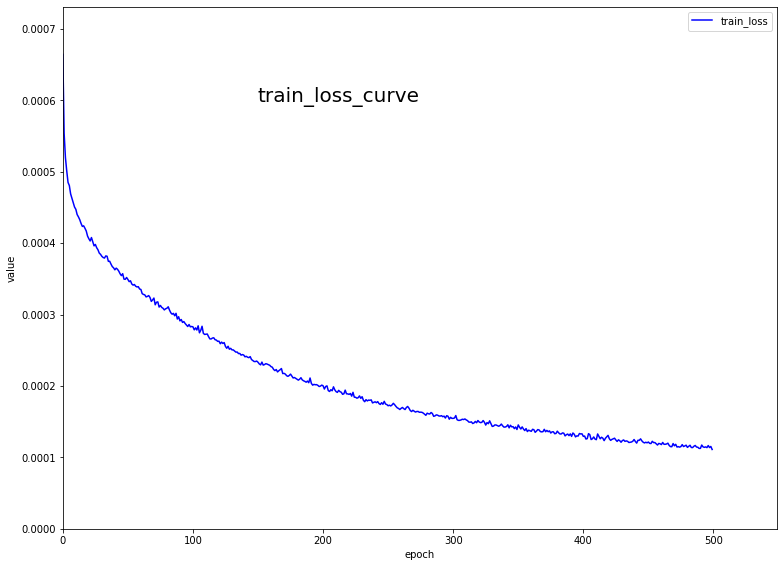

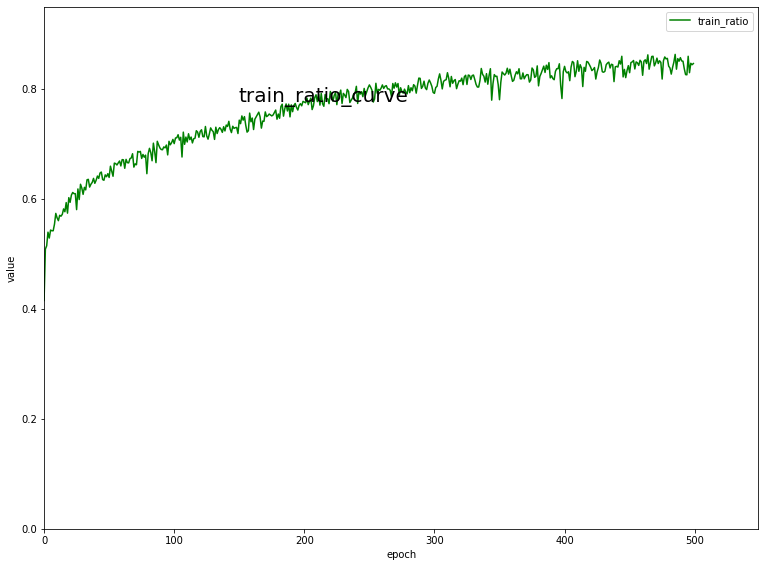

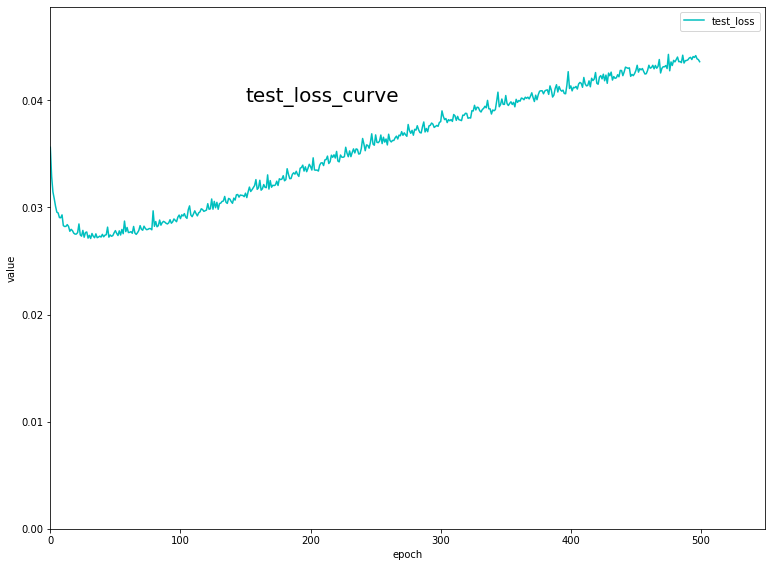

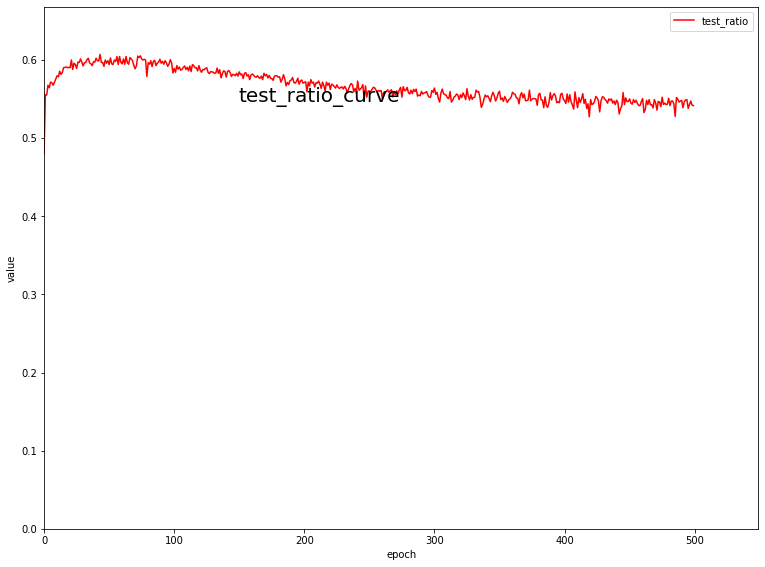

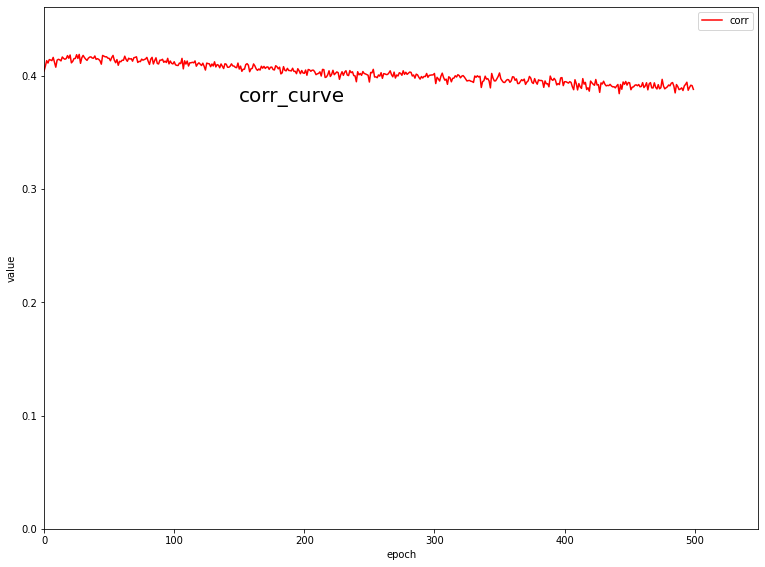

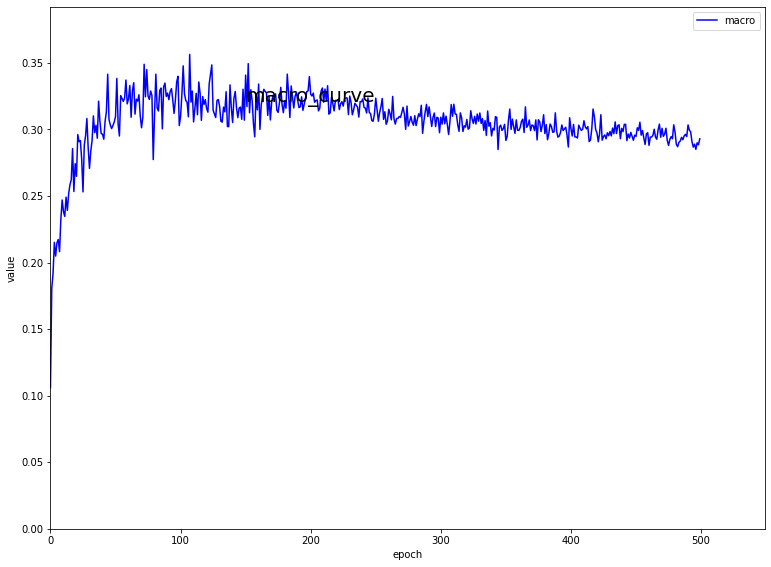

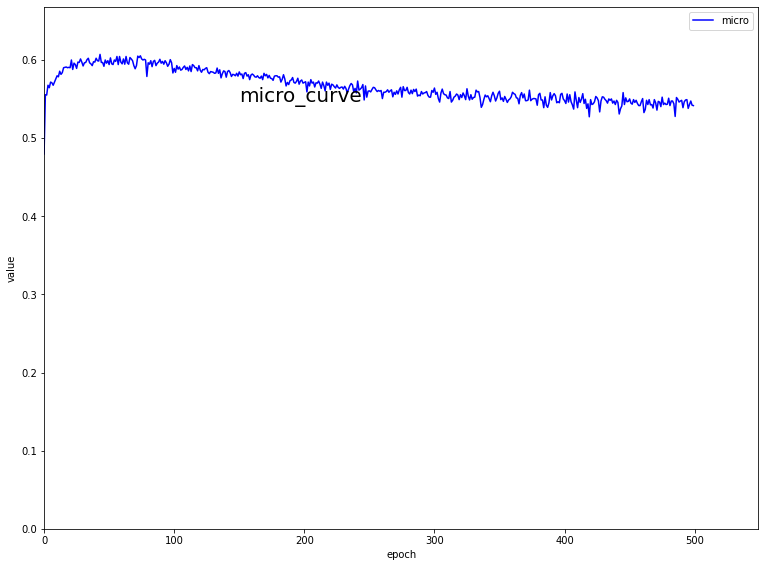

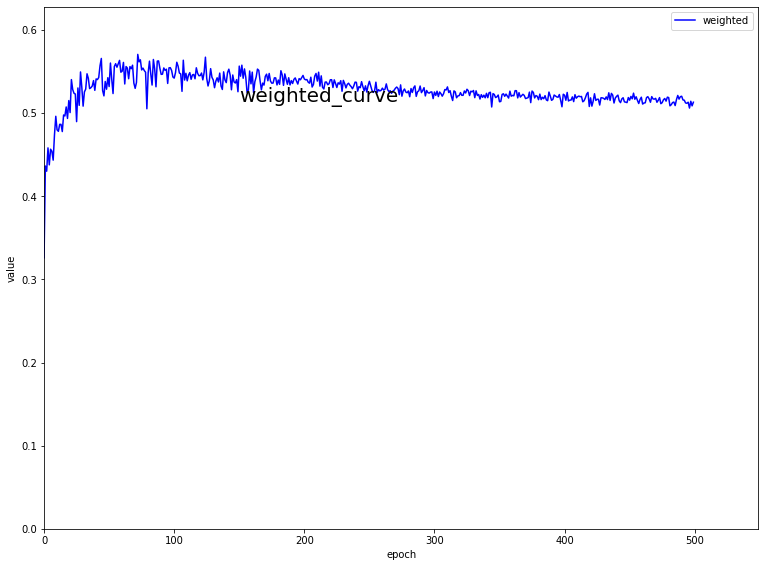

In [70]:
# r  Red
# g  Green
# b   Blue
# c   Cyan
# m  Magenta
# y  Yellow
# k   Black
# w  White

paint('train_loss', 'b')
paint('train_ratio', 'g')
paint('test_loss', 'c')
paint('test_ratio', 'r')
paint('corr', 'r')
paint('macro', 'b')
paint('micro', 'b')
paint('weighted', 'b')

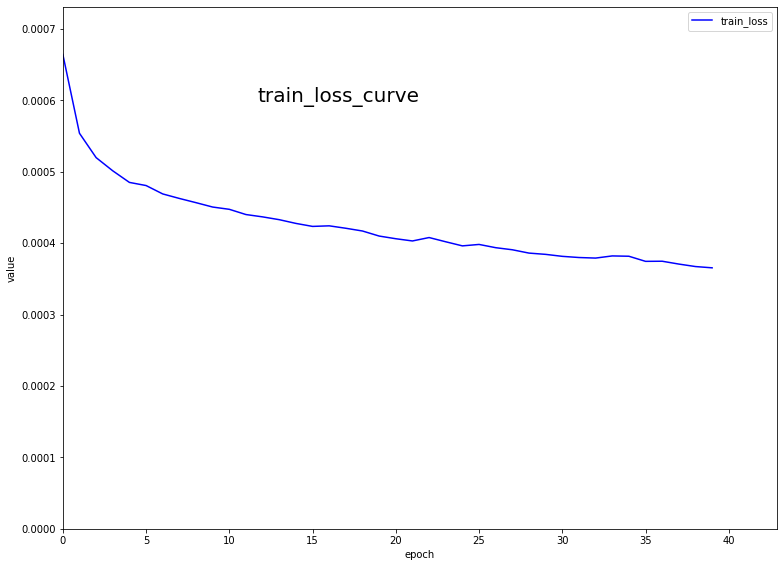

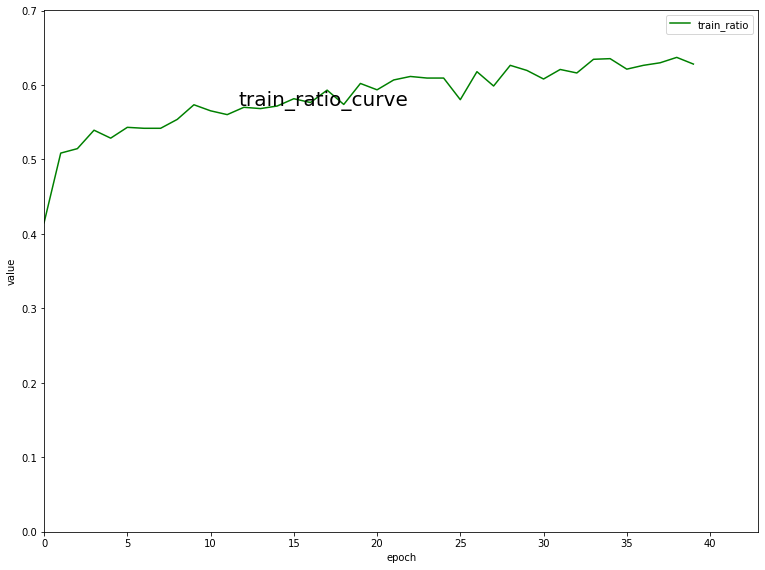

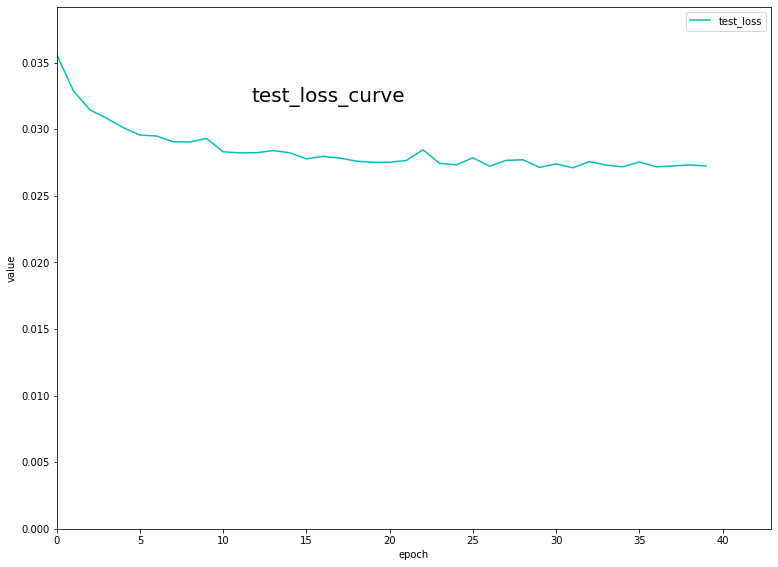

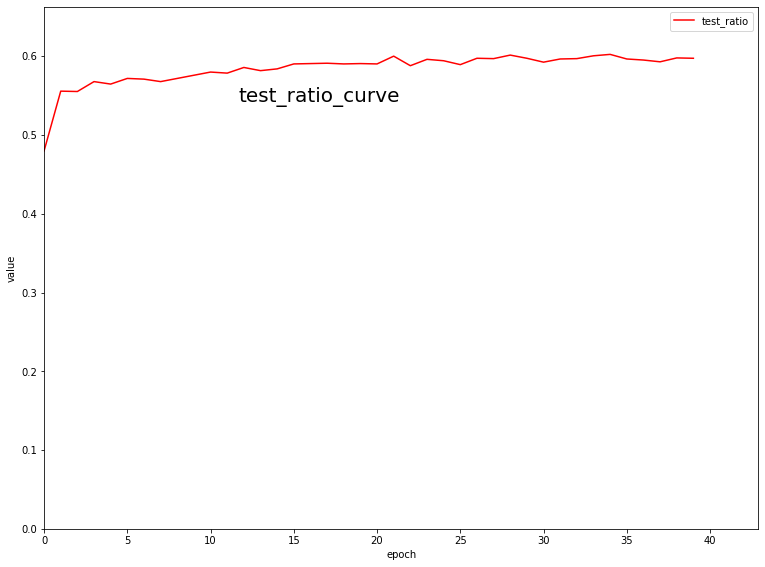

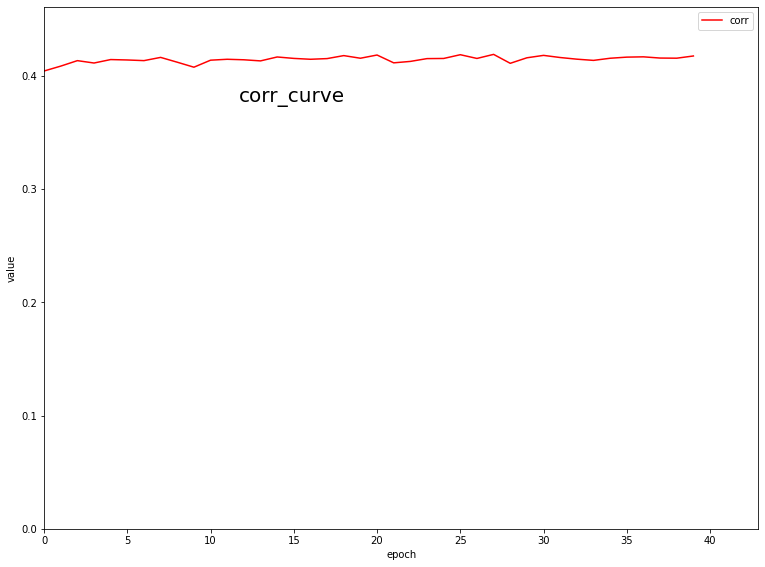

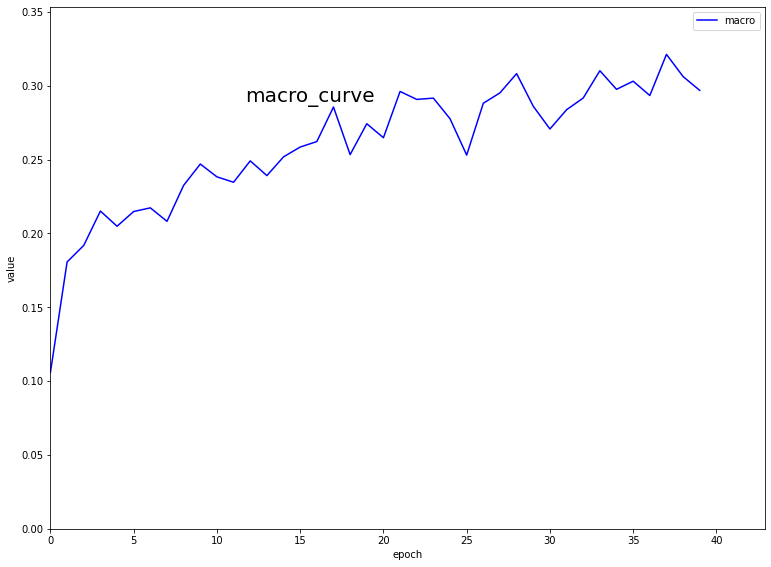

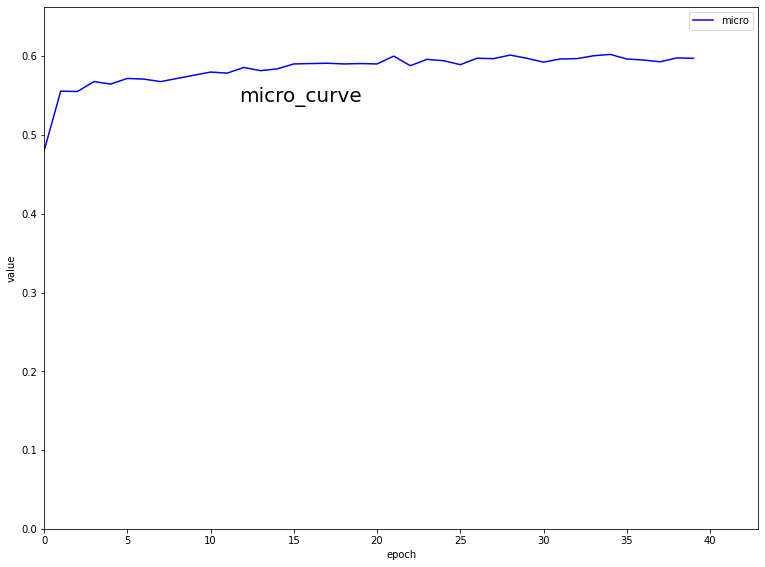

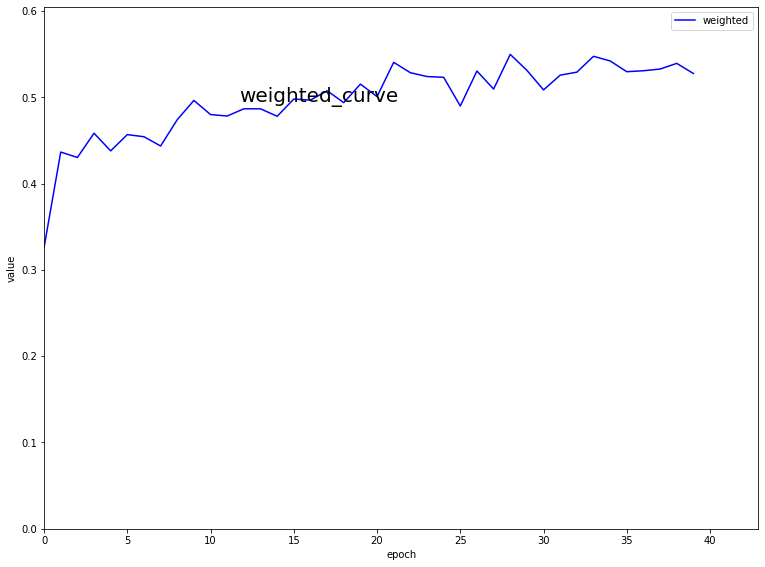

In [73]:
paint('train_loss', 'b', 40)
paint('train_ratio', 'g', 40)
paint('test_loss', 'c', 40)
paint('test_ratio', 'r', 40)
paint('corr', 'r', 40)
paint('macro', 'b', 40)
paint('micro', 'b', 40)
paint('weighted', 'b', 40)

In [33]:
print('argmax test ratio', np.argmax(test_ratio_list))
print('epoch 30', test_ratio_list[29])

argmax test ratio 29
epoch 30 0.6063734290843806


In [13]:
train_size = 2342
test_size = 2228
input_size, hidden_size, output_size = 300, 100, 8
model = TwoLayerNet(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

for epoch in range(500):
    model.train()
    ave_loss = 0.0
    traincnt = 0
    for feat, label in trainloader:
        optimizer.zero_grad()
        pred = model(feat)
        loss = loss_fn(pred, label)
        loss.backward()
        ave_loss += loss.item()
        optimizer.step()
        traincnt += 1
    print('Epoch %d,\t loss %f' % (epoch, ave_loss / traincnt), end='\t')
    
    model.eval()
    evalcnt = 0
    for feat, label in testset:
        if torch.argmax(model(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
            evalcnt += 1
    print('ratio:', evalcnt / test_size)
torch.save(model.state_dict(), 'new_mlp_para.dict')

In [ ]:
net2 = TwoLayerNet(input_size, hidden_size, output_size)
net2.load_state_dict(torch.load('new_mlp_para.dict'))
net2.eval()

cnt = 0
# for feat, label in testset:
pred_emotions = list()
true_emotions = list()
for feat, label in testset:
    # print(label)
    if torch.argmax(net2(torch.Tensor(feat))) == torch.argmax(torch.Tensor(label)):
        cnt += 1
    pred_emotions.append(int(torch.argmax(net2(torch.Tensor(feat))).item()))
    true_emotions.append(int(torch.argmax(torch.Tensor(label)).item()))
    
print('correct:', cnt)
print('ratio:', cnt / test_size)


# 返回值的第一项是皮尔森相关系数，第二项是p_value值。一般来说皮尔森相关系数越大，p_value越小，线性相关性就越大。但是看到note里讲的。p_value不是完全的可靠，当数据量大于500的时候，可能是合理的。
pears = list()
for feat, label in testset:
    pred = torch.Tensor(net2(feat)[0]).detach().numpy()
    # print(pred, label)
    pears.append(pearsonr(label, pred))

# print(pears)
corr = 0
for pair in pears:
    corr += pair[0]
corr /= len(pears)
print(corr)

print(f1_score(true_emotions, pred_emotions, average='macro'))
print(f1_score(true_emotions, pred_emotions, average='weighted'))
# corr -> 0.6611378491929296
# ma -> 0.3289856648150263
# mi -> 0.5501562344438627

In [14]:
# Epoch 0,	 loss 0.044360	ratio: 0.46409335727109513
# Epoch 1,	 loss 0.036265	ratio: 0.5385996409335727
# Epoch 2,	 loss 0.034133	ratio: 0.5471274685816876
# Epoch 3,	 loss 0.032935	ratio: 0.5610412926391383
# Epoch 4,	 loss 0.032075	ratio: 0.5574506283662477
# Epoch 5,	 loss 0.031474	ratio: 0.566427289048474
# Epoch 6,	 loss 0.030763	ratio: 0.5691202872531418
# Epoch 7,	 loss 0.030335	ratio: 0.5749551166965888
# Epoch 8,	 loss 0.029956	ratio: 0.5758527827648114
# Epoch 9,	 loss 0.029613	ratio: 0.5763016157989228
# Epoch 10,	 loss 0.029141	ratio: 0.5803411131059246
# Epoch 11,	 loss 0.028810	ratio: 0.5821364452423698
# Epoch 12,	 loss 0.028460	ratio: 0.5848294434470377
# Epoch 13,	 loss 0.028144	ratio: 0.5879712746858169
# Epoch 14,	 loss 0.028133	ratio: 0.585278276481149
# Epoch 15,	 loss 0.027683	ratio: 0.5866247755834829
# Epoch 16,	 loss 0.027620	ratio: 0.5812387791741472
# Epoch 17,	 loss 0.027368	ratio: 0.5897666068222621
# Epoch 18,	 loss 0.027069	ratio: 0.5843806104129264
# Epoch 19,	 loss 0.026877	ratio: 0.5920107719928187
# Epoch 20,	 loss 0.026766	ratio: 0.5964991023339318
# Epoch 21,	 loss 0.026455	ratio: 0.5861759425493717
# Epoch 22,	 loss 0.026329	ratio: 0.5933572710951526
# Epoch 23,	 loss 0.026253	ratio: 0.5960502692998204
# Epoch 24,	 loss 0.026766	ratio: 0.5861759425493717
# Epoch 25,	 loss 0.025983	ratio: 0.59245960502693
# Epoch 26,	 loss 0.025718	ratio: 0.5956014362657092
# Epoch 27,	 loss 0.025768	ratio: 0.6018850987432675
# Epoch 28,	 loss 0.025556	ratio: 0.5951526032315978
# Epoch 29,	 loss 0.025388	ratio: 0.5951526032315978
# Epoch 30,	 loss 0.025263	ratio: 0.5991921005385996
# Epoch 31,	 loss 0.025343	ratio: 0.5969479353680431
# Epoch 32,	 loss 0.024891	ratio: 0.5929084380610413
# Epoch 33,	 loss 0.024965	ratio: 0.5960502692998204
# Epoch 34,	 loss 0.024825	ratio: 0.599640933572711
# Epoch 35,	 loss 0.024711	ratio: 0.6036804308797128
# Epoch 36,	 loss 0.024679	ratio: 0.5973967684021544
# Epoch 37,	 loss 0.024671	ratio: 0.5947037701974865
# Epoch 38,	 loss 0.024590	ratio: 0.604129263913824
# Epoch 39,	 loss 0.024297	ratio: 0.6023339317773788
# Epoch 40,	 loss 0.024175	ratio: 0.6045780969479354
# Epoch 41,	 loss 0.023943	ratio: 0.6032315978456014
# Epoch 42,	 loss 0.023961	ratio: 0.5973967684021544
# Epoch 43,	 loss 0.023870	ratio: 0.5920107719928187
# Epoch 44,	 loss 0.023921	ratio: 0.5991921005385996
# Epoch 45,	 loss 0.023804	ratio: 0.5942549371633752
# Epoch 46,	 loss 0.023491	ratio: 0.6005385996409336
# Epoch 47,	 loss 0.023675	ratio: 0.5987432675044884
# Epoch 48,	 loss 0.023622	ratio: 0.6000897666068222
# Epoch 49,	 loss 0.023404	ratio: 0.599640933572711
# Epoch 50,	 loss 0.023177	ratio: 0.5978456014362658
# Epoch 51,	 loss 0.023343	ratio: 0.6063734290843806
# Epoch 52,	 loss 0.023444	ratio: 0.6005385996409336
# Epoch 53,	 loss 0.023151	ratio: 0.6009874326750448
# Epoch 54,	 loss 0.022760	ratio: 0.5951526032315978
# Epoch 55,	 loss 0.022900	ratio: 0.6000897666068222
# Epoch 56,	 loss 0.022745	ratio: 0.6018850987432675
# Epoch 57,	 loss 0.022843	ratio: 0.6068222621184919
# Epoch 58,	 loss 0.022551	ratio: 0.6077199281867145
# Epoch 59,	 loss 0.022618	ratio: 0.6036804308797128
# Epoch 60,	 loss 0.022501	ratio: 0.6009874326750448
# Epoch 61,	 loss 0.022388	ratio: 0.6050269299820467
# Epoch 62,	 loss 0.022395	ratio: 0.6032315978456014
# Epoch 63,	 loss 0.022239	ratio: 0.6014362657091562
# Epoch 64,	 loss 0.022342	ratio: 0.6068222621184919
# Epoch 65,	 loss 0.022015	ratio: 0.6063734290843806
# Epoch 66,	 loss 0.022015	ratio: 0.6005385996409336
# Epoch 67,	 loss 0.022017	ratio: 0.5987432675044884
# Epoch 68,	 loss 0.022377	ratio: 0.6032315978456014
# Epoch 69,	 loss 0.021849	ratio: 0.6045780969479354
# Epoch 70,	 loss 0.021738	ratio: 0.6072710951526032
# Epoch 71,	 loss 0.021845	ratio: 0.6095152603231598
# Epoch 72,	 loss 0.021664	ratio: 0.6036804308797128
# Epoch 73,	 loss 0.021468	ratio: 0.6045780969479354
# Epoch 74,	 loss 0.021502	ratio: 0.6027827648114902
# Epoch 75,	 loss 0.021256	ratio: 0.6018850987432675
# Epoch 76,	 loss 0.021228	ratio: 0.6059245960502693
# Epoch 77,	 loss 0.021404	ratio: 0.6068222621184919
# Epoch 78,	 loss 0.021202	ratio: 0.6027827648114902
# Epoch 79,	 loss 0.021095	ratio: 0.5973967684021544
# Epoch 80,	 loss 0.021374	ratio: 0.6032315978456014
# Epoch 81,	 loss 0.020974	ratio: 0.5964991023339318
# Epoch 82,	 loss 0.021045	ratio: 0.6018850987432675
# Epoch 83,	 loss 0.020803	ratio: 0.6063734290843806
# Epoch 84,	 loss 0.020894	ratio: 0.6014362657091562
# Epoch 85,	 loss 0.020889	ratio: 0.6095152603231598
# Epoch 86,	 loss 0.020699	ratio: 0.6068222621184919
# Epoch 87,	 loss 0.020670	ratio: 0.6050269299820467
# Epoch 88,	 loss 0.021004	ratio: 0.6036804308797128
# Epoch 89,	 loss 0.020945	ratio: 0.6032315978456014
# Epoch 90,	 loss 0.020657	ratio: 0.5991921005385996
# Epoch 91,	 loss 0.020475	ratio: 0.6032315978456014
# Epoch 92,	 loss 0.020495	ratio: 0.6014362657091562
# Epoch 93,	 loss 0.020494	ratio: 0.599640933572711
# Epoch 94,	 loss 0.020256	ratio: 0.6032315978456014
# Epoch 95,	 loss 0.020138	ratio: 0.6081687612208259
# Epoch 96,	 loss 0.020215	ratio: 0.5973967684021544
# Epoch 97,	 loss 0.020597	ratio: 0.6014362657091562
# Epoch 98,	 loss 0.020030	ratio: 0.6005385996409336
# Epoch 99,	 loss 0.019943	ratio: 0.6005385996409336